In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/[2024-2025] AN2DL HOMEWORK 1/Definitive_work

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/117Cy5jmRvw7kUjsl1Y2WzOeI_SAmudjh/[2024-2025] AN2DL HOMEWORK 1/Definitive_work


In [ ]:
# Fix randomness and hide warnings
SEED = 42  # Random seed for reproducibility

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.layers import BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Input, Concatenate, Dense, GlobalAveragePooling2D, Dropout
from sklearn.utils.class_weight import compute_class_weight

# Importing specific TensorFlow Keras layers
from tensorflow.keras.layers import (
    Input, Concatenate, Dense, GlobalAveragePooling2D, Dropout,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
)

# Set seed for TensorFlow
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
from datetime import datetime

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
# Load already preprocessed dataset
data = np.load('preprocessed_dataset.npz')
X_train = data['X_train']
X_test = data['X_test']
X_val = data['X_val']
y_train = data['y_train']
y_test = data['y_test']
y_val = data['y_val']

In [ ]:
# Convert one-hot encoded labels to integer labels
if y_train.ndim > 1:
    y_int_train = np.argmax(y_train, axis=1)  # Flatten the one-hot labels to class indices
else:
    y_int_train = y_train  # Already in integer format

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_int_train), y=y_int_train)
class_weights = dict(enumerate(class_weights))

# Convert to categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
# Parameters
INPUT_SHAPE = X_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1]
BATCH_SIZE = 128
LEARNING_RATE = 0.0183
FINE_TUNING_LEARNING_RATE = 1e-4
EPOCHS = 24
FINE_TUNE_EPOCHS = 20
UNFREEZE_RATIO = 0.3

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

# EfficientNetV2S + V2M + V2L

In [ ]:
# Import models
M_1 = tfk.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling="avg",
    include_preprocessing=True,)

M_2 = tfk.applications.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling="avg",
    include_preprocessing=True,)

M_3 = tfk.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling="avg",
    include_preprocessing=True,)

#change models name and avoid chaos
M_1.name = 'M1'
M_2.name = 'M2'
M_3.name = 'M3'

#freeze models weights
M_1.trainable = False
M_2.trainable = False
M_3.trainable = False

#define data augmentation layers
data_augmentation_1 = tfk.Sequential([
    RandomFlip('horizontal'),  # Flip images horizontally
    RandomRotation(0.3),  # Rotate images
    RandomContrast(0.3),  # Random contrast
    RandomBrightness(0.1),  # Random brightness
    RandomZoom(0.2),  # Random zoom
])
data_augmentation_1.name = 'data_augmentation_1'

data_augmentation_2 = tfk.Sequential([
    RandomFlip('horizontal'),  # Flip images horizontally
    RandomRotation(0.3),  # Rotate images
    RandomContrast(0.3),  # Random contrast
    RandomBrightness(0.1),  # Random brightness
    RandomZoom(0.2),  # Random zoom
])
data_augmentation_2.name = 'data_augmentation_2'

data_augmentation_3 = tfk.Sequential([
    RandomFlip('horizontal'),  # Flip images horizontally
    RandomRotation(0.3),  # Rotate images
    RandomContrast(0.3),  # Random contrast
    RandomBrightness(0.1),  # Random brightness
    RandomZoom(0.2),  # Random zoom
])
data_augmentation_3.name = 'data_augmentation_3'

#add data augmentation layers to the base models
input_tensor = Input(shape=INPUT_SHAPE)
augmented_input_1 = data_augmentation_1(input_tensor)
augmented_input_2 = data_augmentation_2(input_tensor)
augmented_input_3 = data_augmentation_3(input_tensor)
Effnet_1_output = M_1(augmented_input_1)
Effnet_2_output = M_2(augmented_input_2)
Effnet_3_output = M_3(augmented_input_3)

#concate model output
x = Concatenate()([Effnet_1_output,Effnet_2_output,Effnet_3_output])
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(OUTPUT_SHAPE, activation='softmax')(x)

#build model
model = Model(inputs=input_tensor, outputs=x)

# Step 8: Compile the Model
model.compile(
    optimizer=Adadelta(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['F1Score', 'recall', 'accuracy']
)

# Print model summary
model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation_1       │ (None, 96, 96, 3)      │              0 │ input_layer_3[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation_2       │ (None, 96, 96, 3)      │              0 │ input_layer_3[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation_3       │ (None, 96, 96, 3)      │              0 │ input_layer_3[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ M1 (Functional)           │ (None, 1280)           │     20,331,360 │ data_augmentation_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ M2 (Functional)           │ (None, 1280)           │     53,150,388 │ data_augmentation_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ M3 (Functional)           │ (None, 1280)           │    117,746,848 │ data_augmentation_3[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3840)           │              0 │ M1[0][0], M2[0][0],    │
│                           │                        │                │ M3[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,966,592 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 8)              │          1,032 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 193,360,444 (737.61 MB)

 Trainable params: 2,131,848 (8.13 MB)

 Non-trainable params: 191,228,596 (729.48 MB)

Epoch 1/24
81/81 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - F1Score: 0.1300 - accuracy: 0.1607 - loss: 2.1273 - recall: 2.4925e-04 - val_F1Score: 0.4319 - val_accuracy: 0.4632 - val_loss: 1.9123 - val_recall: 0.0000e+00
Epoch 2/24
81/81 ━━━━━━━━━━━━━━━━━━━━ 99s 769ms/step - F1Score: 0.2208 - accuracy: 0.2516 - loss: 1.9737 - recall: 0.0022 - val_F1Score: 0.5781 - val_accuracy: 0.6044 - val_loss: 1.7121 - val_recall: 8.7719e-04
Epoch 3/24
81/81 ━━━━━━━━━━━━━━━━━━━━ 60s 739ms/step - F1Score: 0.3019 - accuracy: 0.3314 - loss: 1.8355 - recall: 0.0209 - val_F1Score: 0.6279 - val_accuracy: 0.6447 - val_loss: 1.5055 - val_recall: 0.0719
Epoch 4/24
81/81 ━━━━━━━━━━━━━━━━━━━━ 83s 751ms/step - F1Score: 0.3514 - accuracy: 0.3814 - loss: 1.7151 - recall: 0.0500 - val_F1Score: 0.6481 - val_accuracy: 0.6658 - val_loss: 1.3398 - val_recall: 0.1114
Epoch 5/24
81/81 ━━━━━━━━━━━━━━━━━━━━ 86s 799ms/step - F1Score: 0.3961 - accuracy: 0.4264 - loss: 1.5888 - recall: 0.0938 - val_F1Score: 0.6778 - val_accuracy: 0.

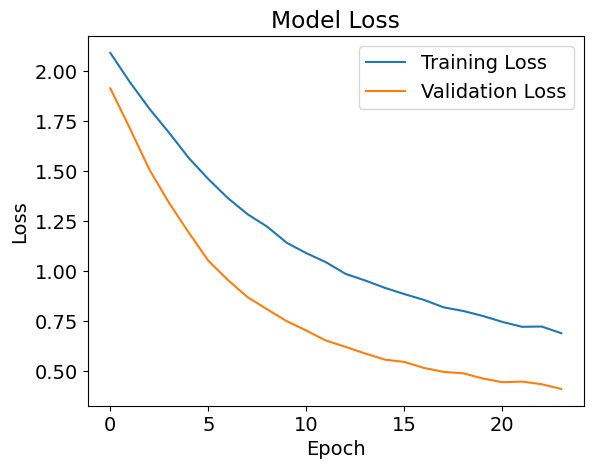

In [ ]:
tfk.backend.clear_session(free_memory=True)

# Transfer Learning
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Print the final training and validation loss
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final training loss: {final_train_loss}")
print(f"Final validation loss: {final_val_loss}")

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Save model
model.save("Triglav.keras")

In [ ]:
# Load the saved model
model = load_model('0.keras')

# Unfreeze specific layers in each EfficientNet model
model.trainable = True

for layer in model.get_layer('M1').layers[:]:
    if  isinstance(layer, BatchNormalization):
            layer.trainable = False

for layer in model.get_layer('M2').layers[:]:
    if  isinstance(layer, BatchNormalization):
            layer.trainable = False

for layer in model.get_layer('M3').layers[:]:
    if  isinstance(layer, BatchNormalization):
            layer.trainable = False

# Unfreeze layers until a specific number of parameters are trainable
target_trainable_params = 5_250_000  # Example: Unfreeze 1 million parameters
current_params = 0

for layer in model.get_layer('M1').layers:
    if current_params >= target_trainable_params:
        break
    if not isinstance(layer, BatchNormalization) and layer.trainable_weights:
        layer.trainable = True
        current_params += layer.count_params()

# Unfreeze layers until a specific number of parameters are trainable
target_trainable_params = 13_500_000  # Example: Unfreeze 1 million parameters
current_params = 0

for layer in model.get_layer('M2').layers:
    if current_params >= target_trainable_params:
        break
    if not isinstance(layer, BatchNormalization) and layer.trainable_weights:
        layer.trainable = True
        current_params += layer.count_params()

# Unfreeze layers until a specific number of parameters are trainable
target_trainable_params = 30_000_000  # Example: Unfreeze 1 million parameters
current_params = 0

for layer in model.get_layer('M3').layers:
    if current_params >= target_trainable_params:
        break
    if not isinstance(layer, BatchNormalization) and layer.trainable_weights:
        layer.trainable = True
        current_params += layer.count_params()

# Compile the model
model.compile(
    optimizer=Adadelta(learning_rate=0.00673),
    loss='categorical_crossentropy',
    metrics=['F1Score', 'recall', 'accuracy', 'precision']
)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - F1Score: 0.7540 - accuracy: 0.7692 - loss: 0.6778 - precision: 0.8503 - recall: 0.6755 - val_F1Score: 0.8468 - val_accuracy: 0.8588 - val_loss: 0.4082 - val_precision: 0.9043 - val_recall: 0.8211
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 111s 709ms/step - F1Score: 0.7575 - accuracy: 0.7716 - loss: 0.6652 - precision: 0.8480 - recall: 0.6678 - val_F1Score: 0.8487 - val_accuracy: 0.8605 - val_loss: 0.4095 - val_precision: 0.9003 - val_recall: 0.8237
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 89s 796ms/step - F1Score: 0.7526 - accuracy: 0.7673 - loss: 0.6693 - precision: 0.8428 - recall: 0.6718 - val_F1Score: 0.8498 - val_accuracy: 0.8614 - val_loss: 0.4006 - val_precision: 0.9043 - val_recall: 0.8289
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 84s 823ms/step - F1Score: 0.7691 - accuracy: 0.7824 - loss: 0.6484 - precision: 0.8565 - recall: 0.6838 - val_F1Score: 0.8494 - val_accuracy: 0.8614 - val_loss: 0.3984 - val_precision: 0.9042 - val_recall: 0.82

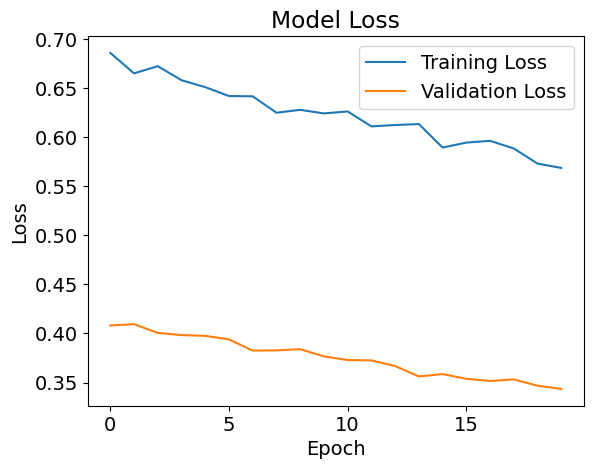

In [ ]:
# Fine-tuning
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=FINE_TUNE_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Print the final training and validation loss
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final training loss: {final_train_loss}")
print(f"Final validation loss: {final_val_loss}")

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Save the model
model.save("Triglav_finetuned.keras")

18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step
Accuracy score over the test set: 0.8786
Precision score over the test set: 0.886
Recall score over the test set: 0.8786
F1 score over the test set: 0.8788


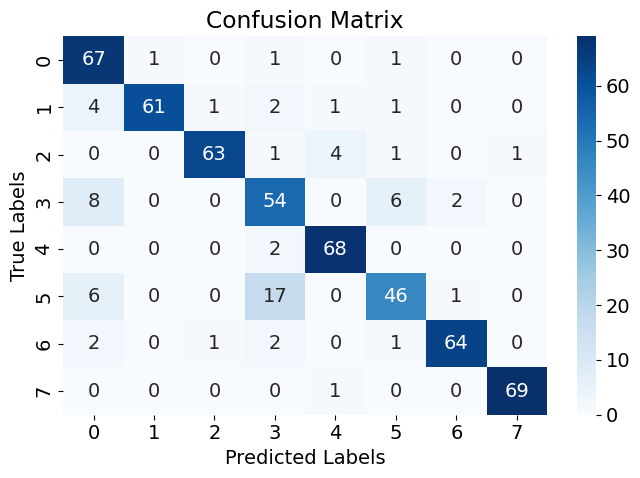

In [ ]:
# Load model1 and model2 if necessary (if models were deleted after training)
model = tf.keras.models.load_model("Triglav_finetuned.keras")

# Make predictions for model1 on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')
test_precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')
test_recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute confusion matrices for both models
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

# Optionally, you can delete the models to free up resources
del model